In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from google.colab import drive
drive.mount('/content/drive')
%ls

Mounted at /content/drive
drive/        X12lam.npy  Xlam.npy       Xrtrlam.npy  Y12.npy
sample_data/  X12.npy     Xrotatlam.npy  Xrtr.npy     Y.npy


In [3]:
X = np.load('X12.npy')
Y = np.load('Y12.npy')

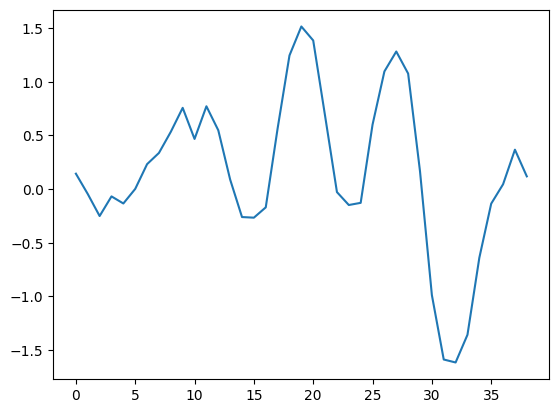

In [5]:
x = X[41,1,:]
plt.plot(x)
plt.show()

In [6]:
#---
def vec2hankel(vec, ncols):
  hankel = np.empty((len(vec)-ncols+1, ncols))
  for i in range(len(hankel)):
    hankel[i] = vec[i:i+ncols]
  return hankel
#---
def hankel2vec(hankel):
  nrows, ncols = hankel.shape
  vec = np.zeros((nrows+ncols-1))
  # first upper triangle of the hankel matrix
  for i in range(ncols):
    vec[i] = np.trace(np.flip(hankel[0:0+ncols,:], axis=0), offset= -ncols+1+i )/(i+1)
    #print(i, vec[i])
  # the body of the matrix
  for i in range(ncols+1,nrows):
    vec[i-1] = np.trace(np.flip(hankel[i-ncols:i,:], axis=0))/ncols
    #print(i, vec[i])
  # the rest of the matrix
  for i in range(nrows,nrows+ncols):
    vec[i-1] = np.trace(np.flip(hankel[nrows-ncols:nrows,:], axis=0), offset= -nrows+i )/(ncols+nrows-i)
    #print(nrows-ncols,nrows, -nrows+i, ncols+nrows-i)
    #print(hankel[nrows-ncols:nrows,:])
    #print(i, vec[i])
  return vec
#---
def ssa(vec, ncols, ncomps):
  h  = vec2hankel(x,ncols)
  u, s, vt = np.linalg.svd(h)
  # Reconstruct the first ncomps SVD sigular values
  h1 = u[:,0:ncomps] @ np.diag(s[0:ncomps]) @ vt[0:ncomps,:]
  hr = u[:,0:ncomps] @ np.diag(s[0:ncomps]) # @ vt[0:ncomps,:] # Suppress rotation
  # Reconstruct the sourse vector of the same length
  x1 = hankel2vec(h1)
  # Return both the hankel matrix and the vector
  # Return results of analysis
  lambd = s[0:ncomps]         # NEW
  rotat =  vt[0:ncomps,:]     # NEW
  # rotat = rotat.reshape(-1)   # NEW
  return x1, h1, hr, lambd, rotat

-4.80356072787363


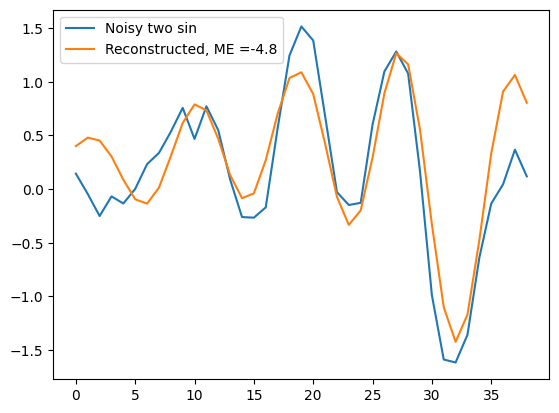

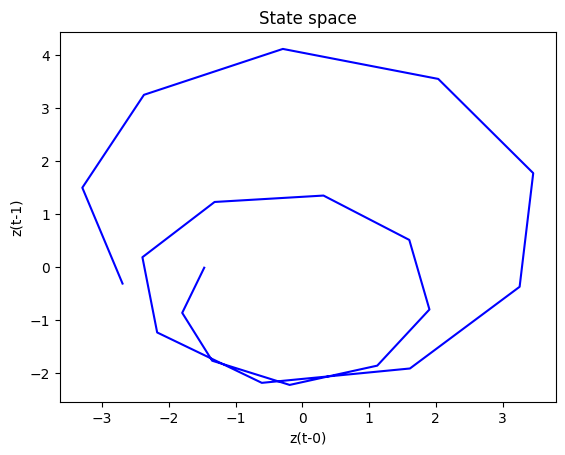

In [7]:
# Test series one
### x = np.array([1,2,3,4,5,6,7,8,9])
# Test series two
### x = np.array(np.arange(101, 128))
# Test series periodic signal
### x = np.linspace(0, 16*np.pi, 880)
### x = np.sin(x)  + 0.3 * np.cos(x/2) + np.random.normal(0, 0.1, size=len(x))
#---
ncols  = 20
ncomps = 3
x1, h1, _, _, _  = ssa(x, ncols, ncomps)
print(np.sum(x-x1))

plt.plot(x, label='Noisy two sin')
plt.plot(x1, label= f'Reconstructed, ME ={round(np.sum(x-x1),2)}')
plt.legend()
plt.show()
#---
x1, h1, hr, _, _  = ssa(x, ncols, 2) # To plot the phase
fig, ax = plt.subplots()
#ax.scatter(h1[:,0], h1[:,1])
ax.plot(hr[:,0], hr[:,1], 'b-')
#---
ax.set_title("State space")
ax.set_xlabel("z(t-0)")
ax.set_ylabel("z(t-1)")
plt.show()

In [33]:
def plot_2_comps(x, y, ncols = 20, ncomps = 3):
  x1, h1, _, lambd, rotat  = ssa(x, ncols, ncomps)
  # print(np.sum(x-x1))
  plt.plot(x, label='Noisy two sin')
  plt.plot(x1, label= f'Reconstructed, ME ={round(np.sum(x-x1),2)}')
  plt.legend()
  plt.title(y)
  plt.show()
  #---
  x1, h1, hr, _, _  = ssa(x, ncols, 2) # To plot the phase
  fig, ax = plt.subplots()
  #ax.scatter(h1[:,0], h1[:,1])
  ax.plot(hr[:,0], hr[:,1], 'b-')
  #---
  ax.set_title("State space")
  ax.set_xlabel("z(t-0)")
  ax.set_ylabel("z(t-1)")
  plt.title(y)
  plt.show()
  #---
  plt.bar(np.arange(len(lambd)), lambd, color='skyblue', edgecolor='black')
  plt.show()
  #---
  #plt.bar(np.arange(len(rotat)), rotat, color='red', edgecolor='black')
  plt.imshow(rotat, cmap="viridis", interpolation="nearest")
  plt.show()
  # print(rotat)


In [89]:
Xrotat = np.empty([0,15])
Xrotatlam = np.empty([0,18])
Xrtr = np.empty([0,9])
Xrtrlam = np.empty([0,12])
Xlam = np.empty([0,3])

for x, y in zip(X, Y):
  x = x.flatten()
  x1, h1, _, lambd, rotat  = ssa(x, 20, 3)
  rotatT = rotat.T
  rtr =  rotat @ rotatT
  rtr = rtr.flatten()
  rtrlam = np.concatenate((rtr, lambd))
  rotat = rotat[:,:5]
  rotat = rotat.flatten()
  rotatlam = np.concatenate((rotat, lambd))
  Xrotat = np.append(Xrotat, [rotat], axis=0)
  Xrotatlam = np.append(Xrotatlam, [rotatlam], axis=0)
  Xrtr = np.append(Xrtr, [rtr], axis = 0)
  Xrtrlam = np.append(Xrtrlam, [rtrlam], axis=0)
  Xlam = np.append(Xlam, [lambd], axis=0)

np.save('X12rotat.npy', Xrotat)
np.save('X12rotatlam.npy', Xrotatlam)
np.save('X12rtr.npy', Xrtr)
np.save('X12rtrlam.npy', Xrtrlam)
np.save('X12lam.npy', Xlam)


In [81]:
for x, y in zip(X, Y):
  x = x.flatten()
  plot_2_comps(x, y)

Output hidden; open in https://colab.research.google.com to view.

In [90]:
X = np.load('X12lam.npy')
Y = np.load('Y12.npy')


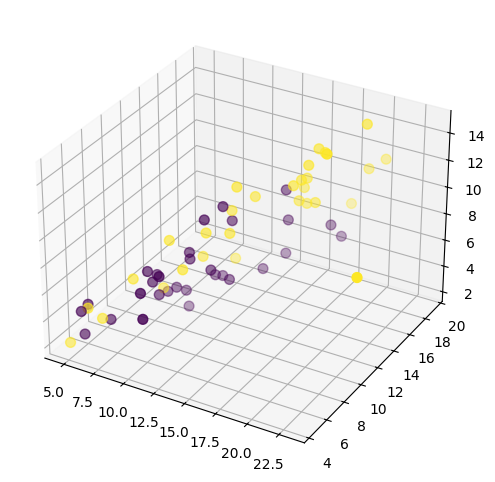

In [91]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=Y, cmap="viridis", marker="o", s=50)
plt.show()